Buscar pasta Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importar Libs...

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import HMDB51
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import random
from tqdm import tqdm
from PIL import Image
import copy
import json


Dataset Class

In [4]:
class FrameDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.frames_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.slice_size = 10

    def __len__(self):
        return len(self.frames_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # need to take 10 frames and stack them on 1 tensor
        # ()-> second index has to be 1 because id column (3 columns)
        # ()-> why have to be NOT??? is wrong!! but works..
        all_frames = [f for f in os.listdir(os.path.join(self.root_dir, str(self.frames_csv.iloc[idx, 0]))) if
                      not os.path.isfile(f)]
        # random get 10 consecutive frames from all video frames in folder
        if len(all_frames) > (self.slice_size):
            start = random.randrange(len(all_frames) - self.slice_size)
            frames = all_frames[start: start + self.slice_size]
        else:
            frames = all_frames

        images = []
        # load the images
        for frame in frames:
            path = os.path.join(self.root_dir, str(self.frames_csv.iloc[idx, 0])) + '/' + frame
            images.append(Image.open(path).convert('RGB'))
        transform = transforms.Compose([
            transforms.Resize((240, 320), ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])])
        # apply tansforms and condense all the images in 1 tensor
        tensors = []
        for image in images:
            tensors.append(transform(image))
        final_image = torch.stack(tensors, dim=1)
        tag = int(self.frames_csv.iloc[idx, 1])
        return final_image, tag

Criar Dataset e Dataloader

In [5]:
# hmdb_data_dir = "/home/jrola/PycharmProjects/pytorch_CTM/data/hmdb4_org"
# hmdb_label_dir = "/home/jrola/PycharmProjects/pytorch_CTM/data/testTrainMulti_7030_splits"
hmdb_frames_dir = "/content/drive/MyDrive/Estágio/hmdb4_frames"
train_labels = "/content/drive/MyDrive/Estágio/data_jrola/hmdb4_labels80.csv"
test_labels = "/content/drive/MyDrive/Estágio/data_jrola/hmdb4_labels20.csv"

batch_size = 5

# create train loader (allowing batches and other extras)
# train_dataset = HMDB51(hmdb_data_dir, hmdb_label_dir, frames_per_clip=frames_per_clip, step_between_clips=step_between_clips, train=True, transform=tfs)
train_dataset = FrameDataset(
    csv_file=train_labels,
    root_dir=hmdb_frames_dir,
)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# create test loader (allowing batches and other extras)
# test_dataset =  HMDB51(hmdb_data_dir, hmdb_label_dir, frames_per_clip=frames_per_clip, step_between_clips=step_between_clips, train=False, transform=tfs)
test_dataset = FrameDataset(
    csv_file=test_labels,
    root_dir=hmdb_frames_dir,
)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Treino do modelo

In [24]:

# Train Network
def train_model(model, criterion, optimizer, scheduler, stats, num_epochs=4):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == 'train':
                data, tag = next(iter(train_dataloader))
                for data, tag in tqdm(train_dataloader):
                    data = data.to(device)
                    tag = tag.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(data)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, tag)
                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * data.size(0)
                    running_corrects += torch.sum(preds == tag)

                    scheduler.step()
                    # unindent this!
                epoch_loss = running_loss / len(train_dataset)
                epoch_acc = running_corrects.double() / len(train_dataset)
                stats[phase + '_loss'].append(float(epoch_loss))
                stats[phase + '_acc'].append(float(epoch_acc))
            else:
                for data, tag in tqdm(test_dataloader):
                    data, tag = next(iter(test_dataloader))
                    data = data.to(device)
                    tag = tag.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(data)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, tag)

                    # statistics
                    running_loss += loss.item() * data.size(0)
                    running_corrects += torch.sum(preds == tag)
                    # unindent this!
                epoch_loss = running_loss / len(test_dataloader)
                epoch_acc = running_corrects.double() / len(test_dataset)
                stats[phase + '_loss'].append(float(epoch_loss))
                stats[phase + '_acc'].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


Função loop alternativa

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, stats):
    size = len(dataloader.dataset)
    count = 0
    for X,y in tqdm(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stats['train_loss'].append(loss.item())
        if count % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")
        count += 1

def test_loop(dataloader, model, loss_fn, stats):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    stats['val_loss'].append(test_loss)
    stats['val_acc'].append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Parametrizar o modelo

In [7]:
## prepare the model


class_name_to_label_path = '/content/drive/MyDrive/Estágio/class_name_to_label_4.json'
f = open(class_name_to_label_path)
classes = json.load(f)
f.close()

model_ft = torchvision.models.video.r3d_18(pretrained=True, progress=True)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(512, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0,
                                amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


Correr o loop treino

In [8]:
## train and evaluate

stats = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
num_epochs = 4
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, stats, num_epochs)

NameError: ignored

Loop alternativo

In [ ]:
stats = {'train_loss':[], 'val_loss':[], 'val_acc':[]}
num_epochs=3
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_ft, criterion, optimizer_ft, stats)
    test_loop(validate_dataloader, model_ft, criterion, stats)
print("Done!")

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  1%|          | 1/95 [00:17<27:45, 17.72s/it]

loss: 0.817263


 21%|██        | 20/95 [06:05<22:23, 17.91s/it]

Print estatísticas

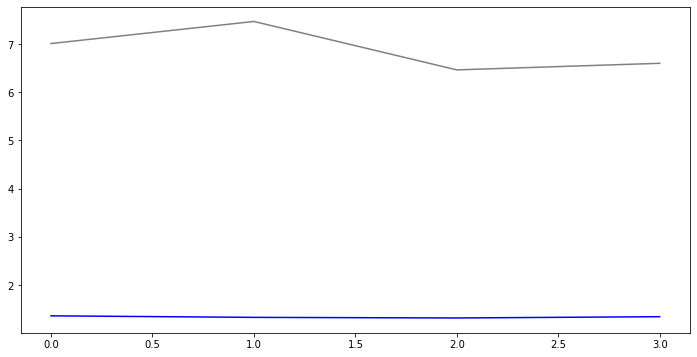

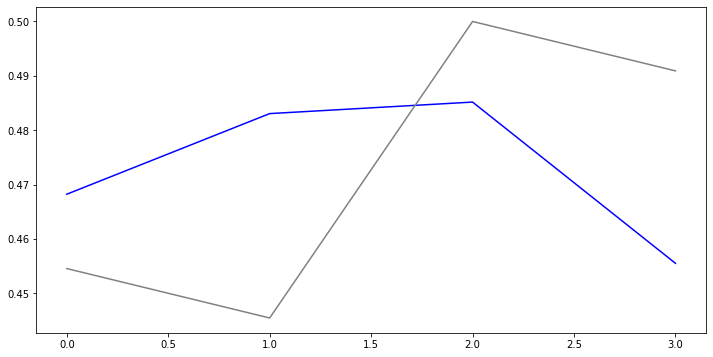

In [27]:
## Show results graphs

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(0, 10, 0.1)
y = stats['train_loss']
z = stats['val_loss']
ax.plot(y, color='blue')
ax.plot(z, color='grey')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
y = stats['train_acc']
z = stats['val_acc']
ax.plot(y, color='blue')
ax.plot(z, color='grey')
plt.show()
